In [1]:
import sys
sys.path.append(r"C:\Users\trund\QRT")

from backtest.backtesting import FunctionStrategy, Backtester # To backtest the strategy
import backtest.backtest_results as btr
import eda_pipeline 
import eda_package.descriptive as eda

from typing import Optional, List, Tuple, Dict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm 
import scipy.stats as stats
import yfinance as yf

In [ ]:
tickers = [
    "JPM",   # JPMorgan (NYSE)
    "GS",    # Goldman Sachs (NYSE)
    "MS",    # Morgan Stanley (NYSE)
    "BAC",   # Bank of America (NYSE)
    "C",     # Citigroup (NYSE)
    "UBS",   # UBS (NYSE / SIX)
    "BARC.L",# Barclays (LSE)
    "HSBA.L",# HSBC (LSE)
    "BNP.PA" # BNP Paribas (Euronext Paris)
]


dates = (pd.Timestamp("2022-01-01"), pd.Timestamp("2024-12-31"))
interval = "1d"

data = yf.download(tickers, start=dates[0], end=dates[1], interval=interval, auto_adjust=False)
#data.columns = [f"{ticker}_{col}" for col, ticker in data.columns]

data.dropna()

[*********************100%***********************]  9 of 9 completed


In [19]:
eda_pipeline.missing_and_duplicates(data)

Total rows: 774, Duplicated rows: 0

Top missing columns:
                  missing_count  missing_percentage
Price     Ticker                                   
Adj Close BAC                22              2.8424
          C                  22              2.8424
          GS                 22              2.8424
          UBS                22              2.8424
          MS                 22              2.8424
          JPM                22              2.8424
High      C                  22              2.8424
          BAC                22              2.8424
Close     UBS                22              2.8424
          BAC                22              2.8424
          GS                 22              2.8424
          C                  22              2.8424
          MS                 22              2.8424
          JPM                22              2.8424
Low       C                  22              2.8424
          GS                 22              2.8424
      

In [20]:
# What to do with missing data? We hunt for the missing data 
missing_analysis = data.copy()
missing_analysis.columns = [(f"{ticker}_{column}") for column, ticker in data.columns]

# Finding all rows with missing data
missing_analysis[missing_analysis.isna().any(axis=1)].index


DatetimeIndex(['2022-01-03', '2022-01-17', '2022-02-21', '2022-04-18',
               '2022-05-02', '2022-05-30', '2022-06-02', '2022-06-03',
               '2022-06-20', '2022-07-04', '2022-08-29', '2022-09-05',
               '2022-09-19', '2022-11-24', '2022-12-27', '2023-01-02',
               '2023-01-16', '2023-02-20', '2023-04-10', '2023-05-01',
               '2023-05-08', '2023-05-29', '2023-06-19', '2023-07-04',
               '2023-08-28', '2023-09-04', '2023-11-23', '2023-12-26',
               '2024-01-15', '2024-02-19', '2024-04-01', '2024-05-01',
               '2024-05-06', '2024-05-27', '2024-06-19', '2024-07-04',
               '2024-08-26', '2024-09-02', '2024-11-28', '2024-12-26'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [21]:
# remove all missing data for now - unless later we don't want to 
data = data.dropna()

## Basic Univariate Plots for Adj_Close 

In [25]:
tickers = [
    "JPM",   # JPMorgan (NYSE)
    "GS",    # Goldman Sachs (NYSE)
    "MS",    # Morgan Stanley (NYSE)
    "BAC",   # Bank of America (NYSE)
    "C",     # Citigroup (NYSE)
    "UBS",   # UBS (NYSE / SIX)
    "BARC.L",# Barclays (LSE)
    "HSBA.L",# HSBC (LSE)
    "BNP.PA" # BNP Paribas (Euronext Paris)
]


dates = (pd.Timestamp("2022-01-01"), pd.Timestamp("2024-12-31"))
interval = "1d"

data = yf.download(tickers, start=dates[0], end=dates[1], interval=interval, auto_adjust=False)
data.dropna(inplace=True)

[*********************100%***********************]  9 of 9 completed


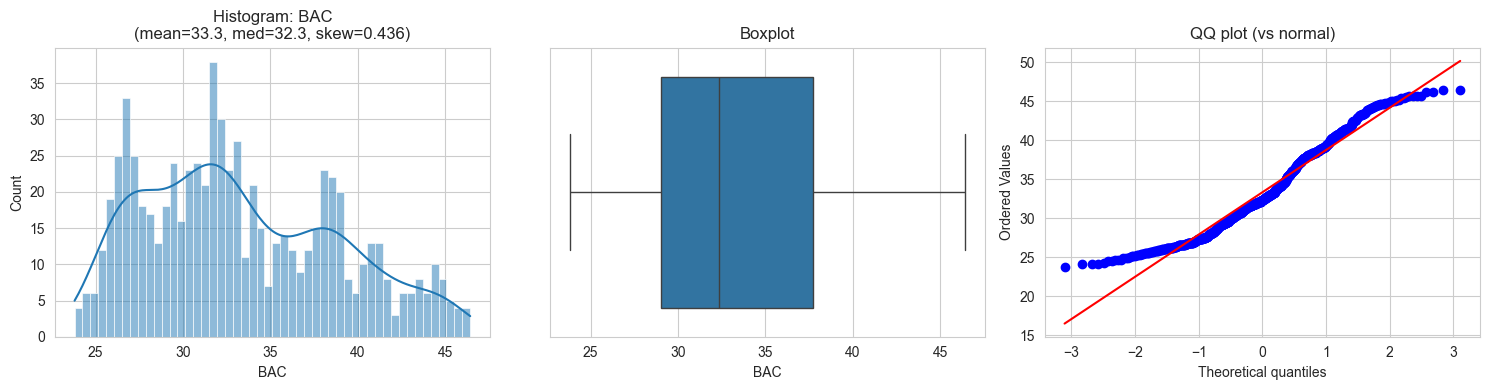

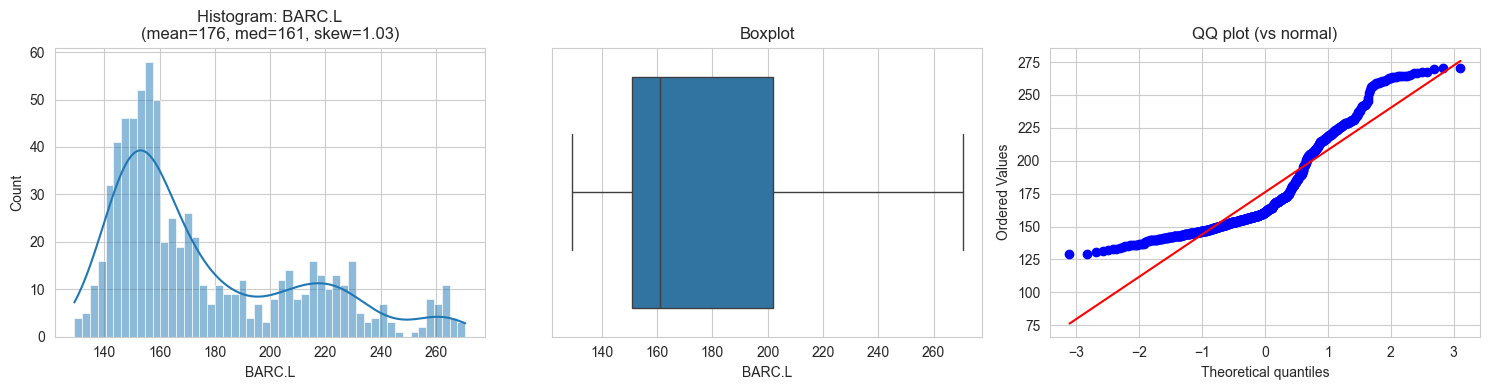

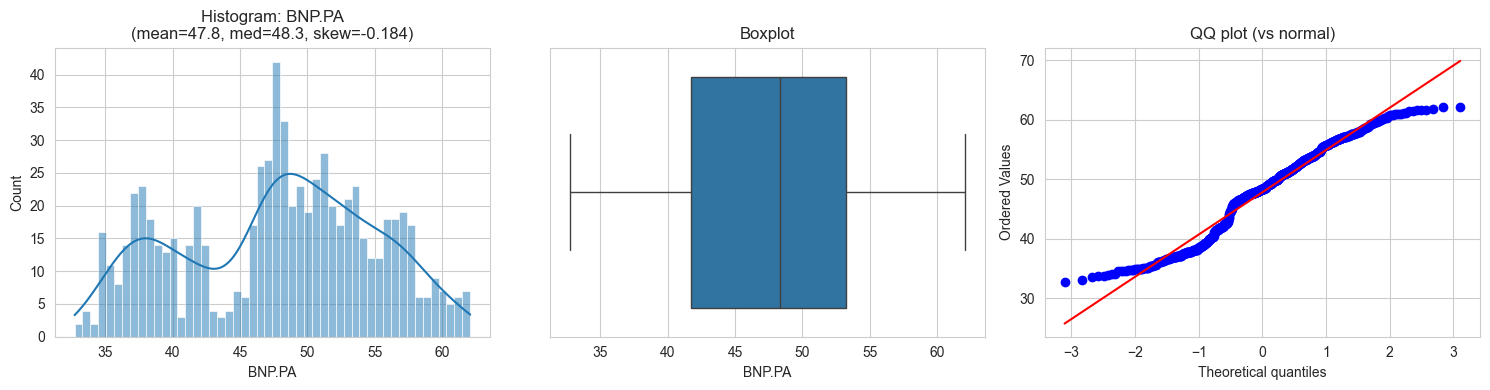

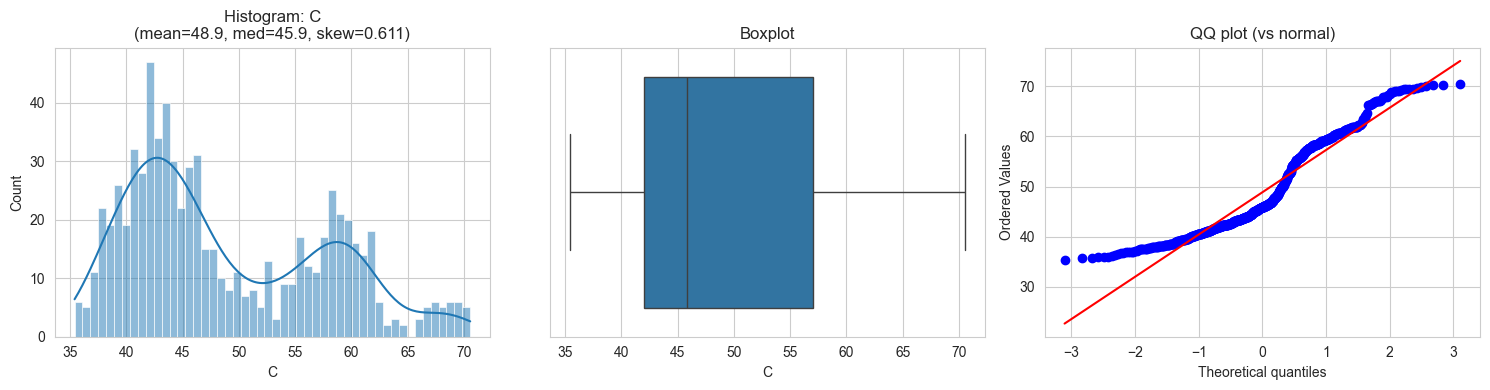

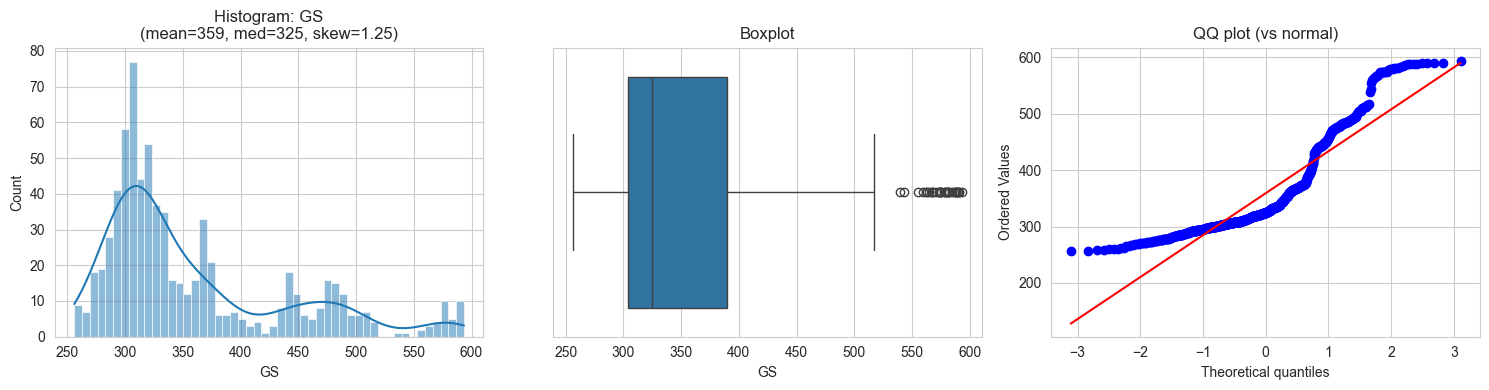

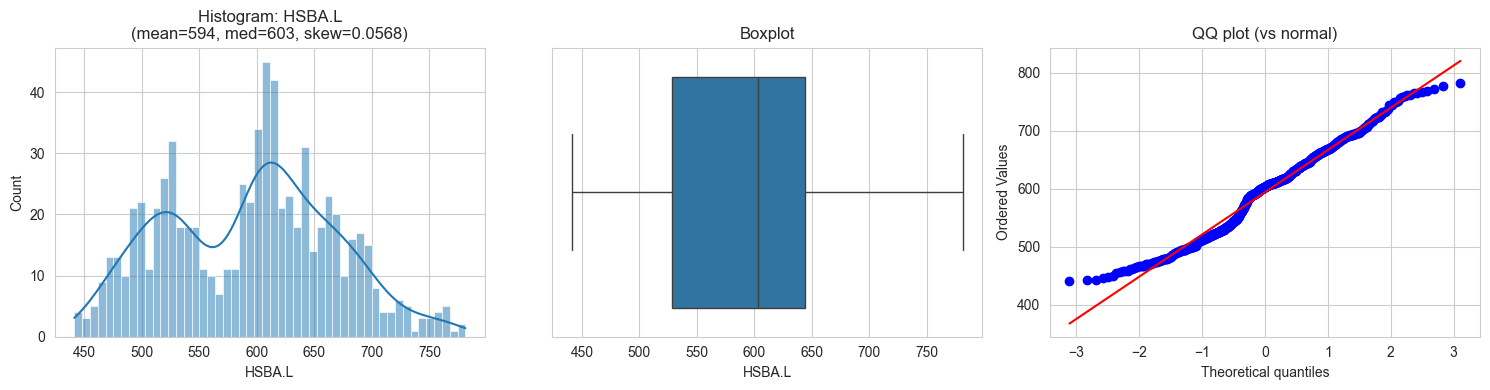

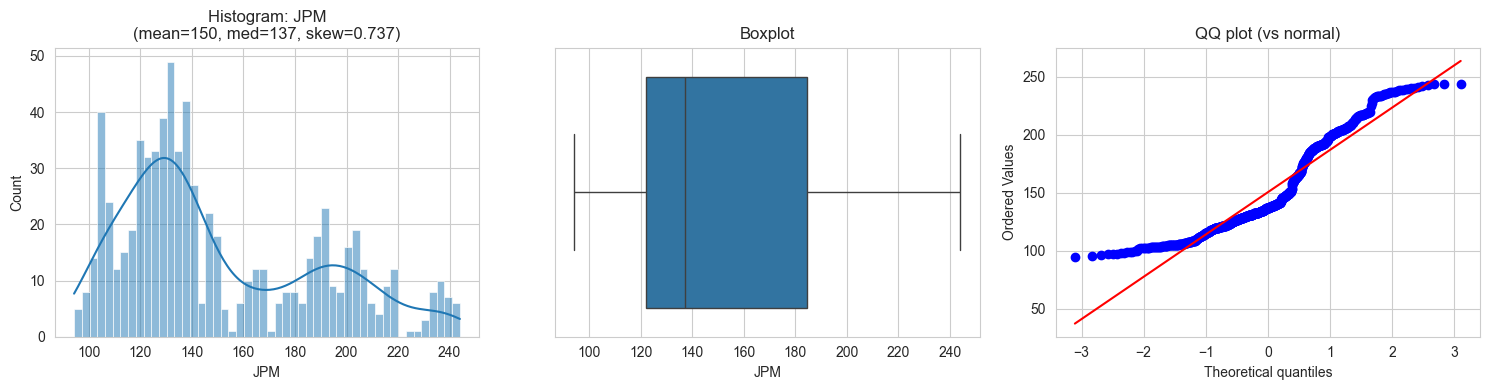

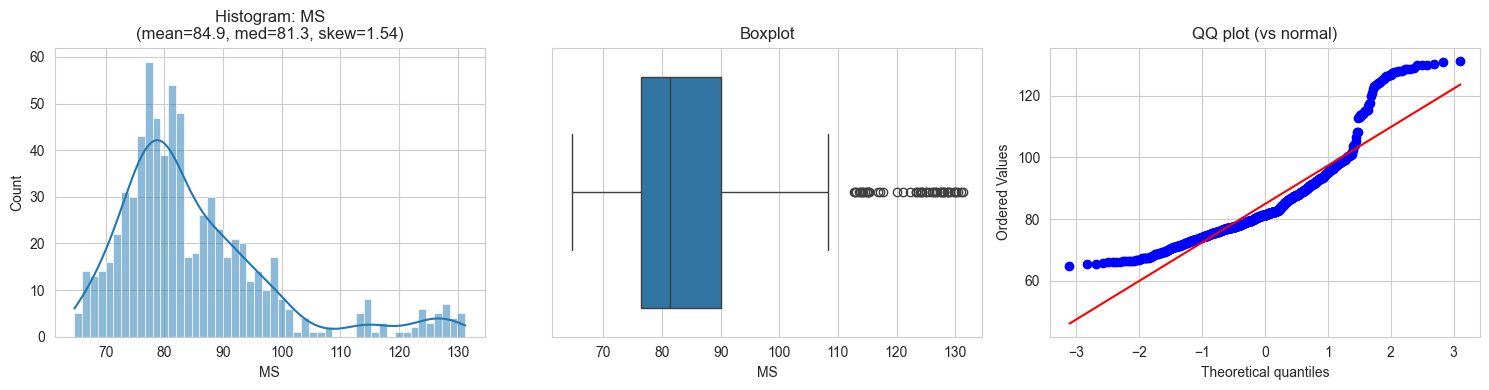

In [26]:
eda.plot_numeric_univariate(data["Adj Close"], cols=data["Adj Close"].columns.tolist(), bins=50)

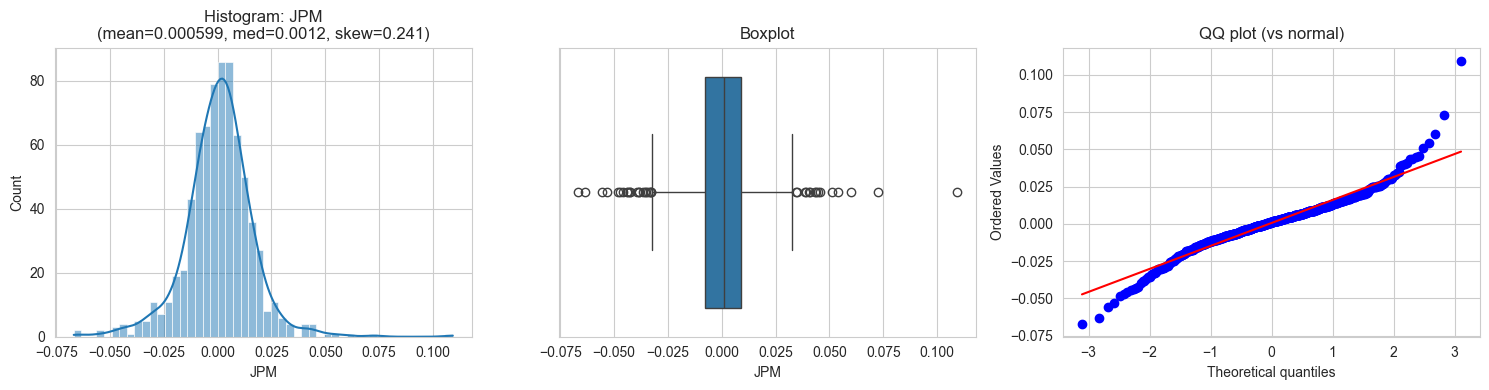

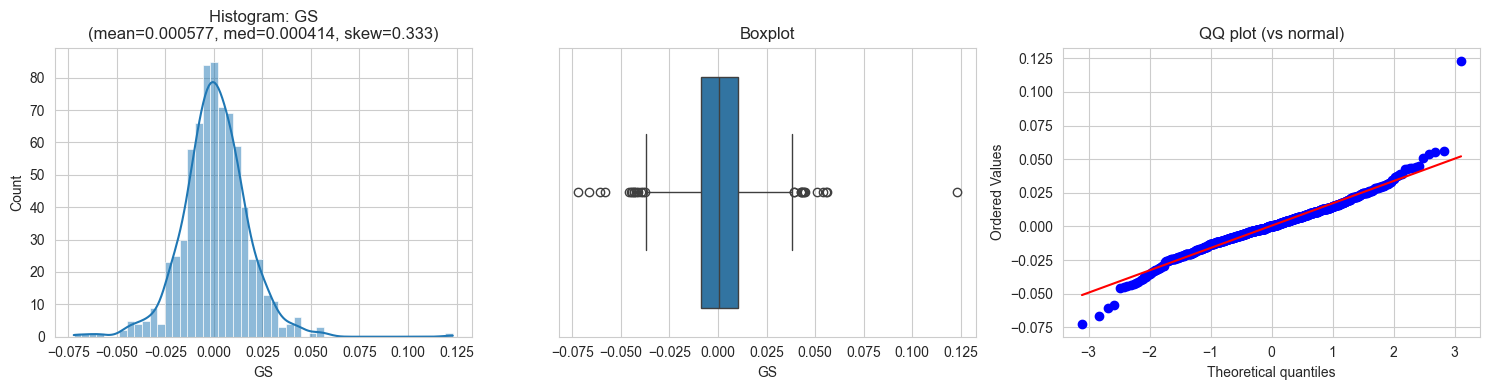

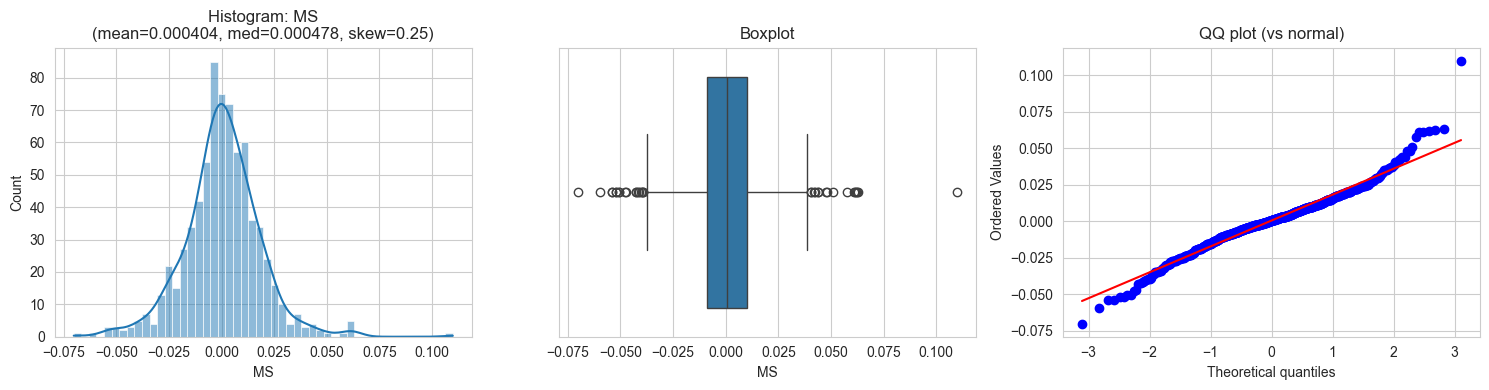

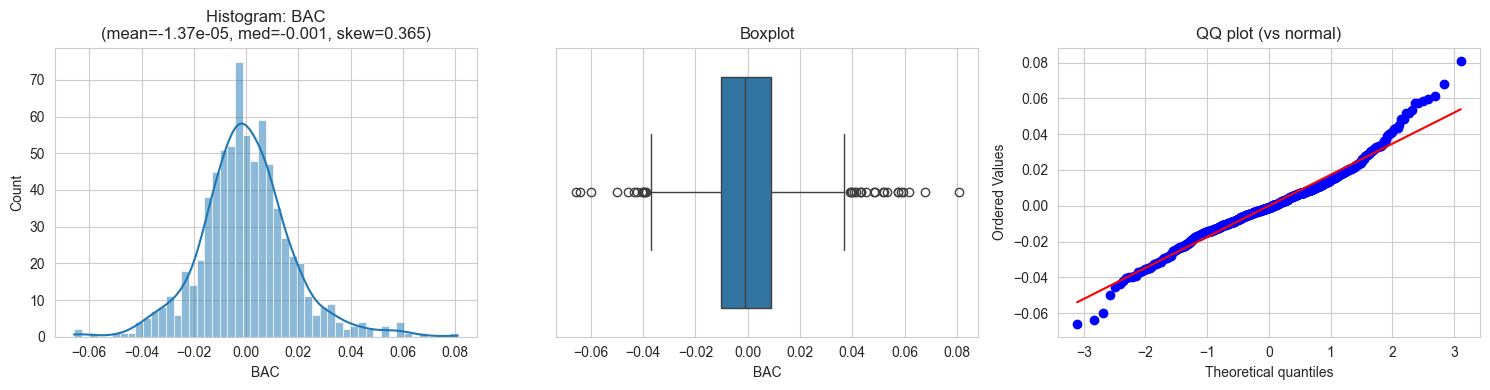

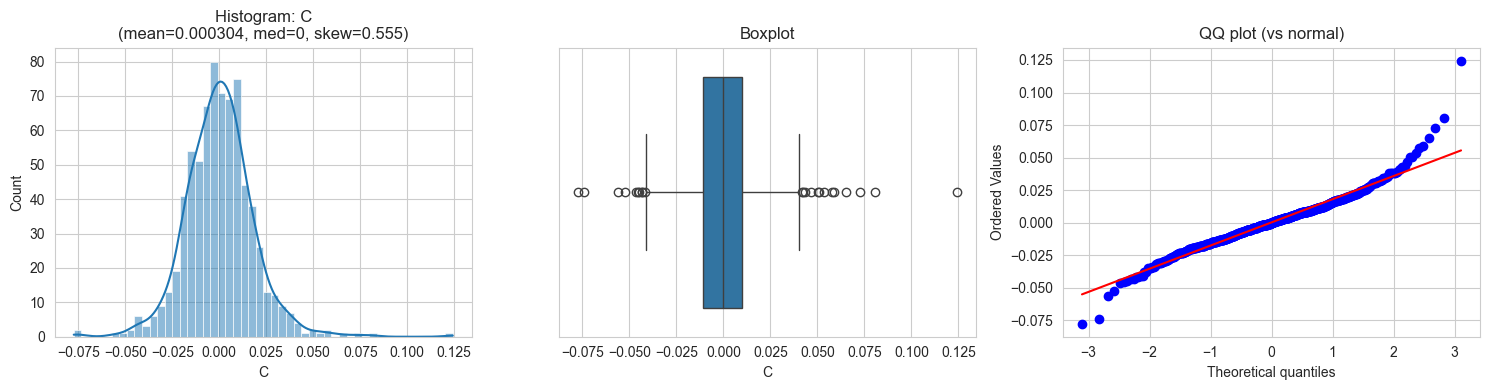

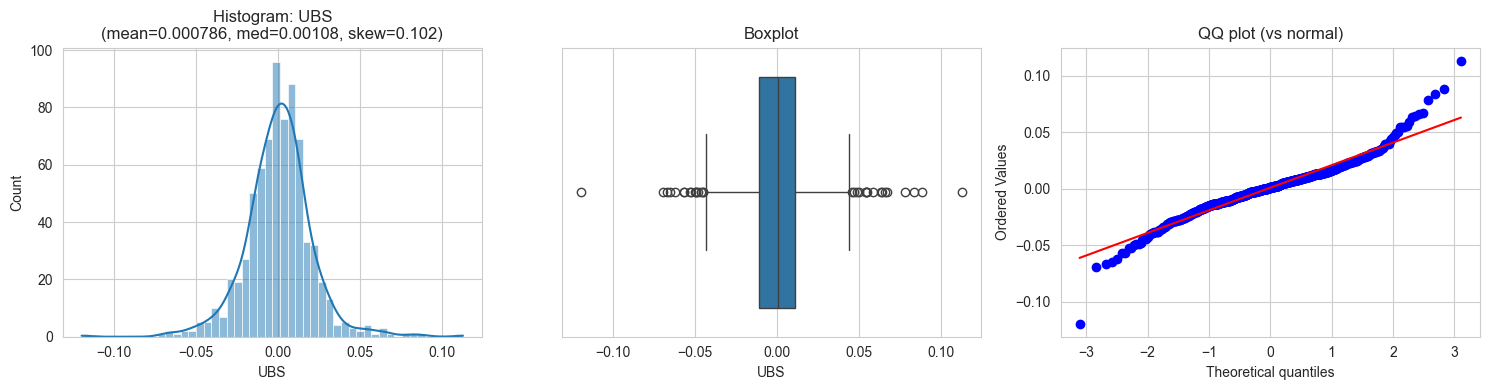

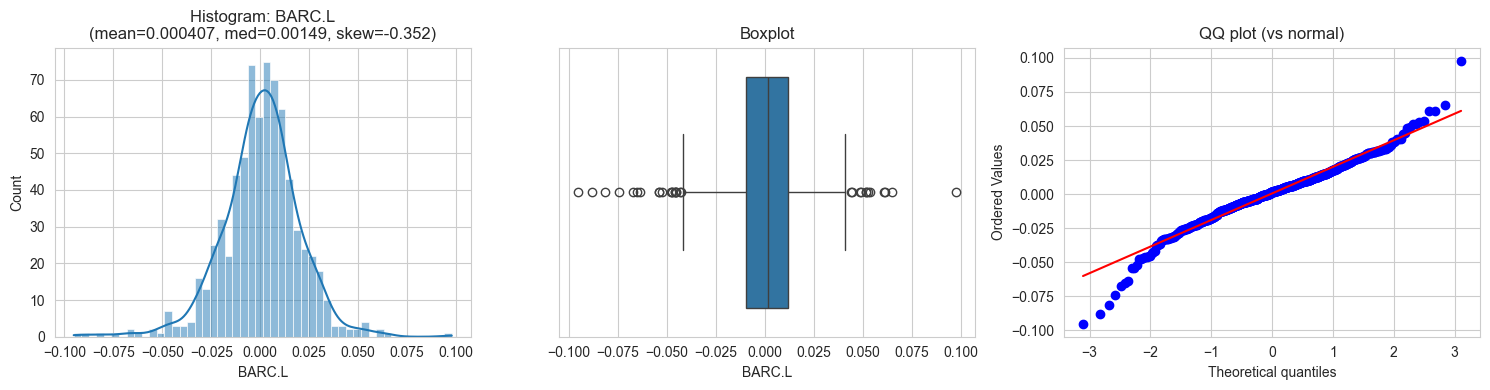

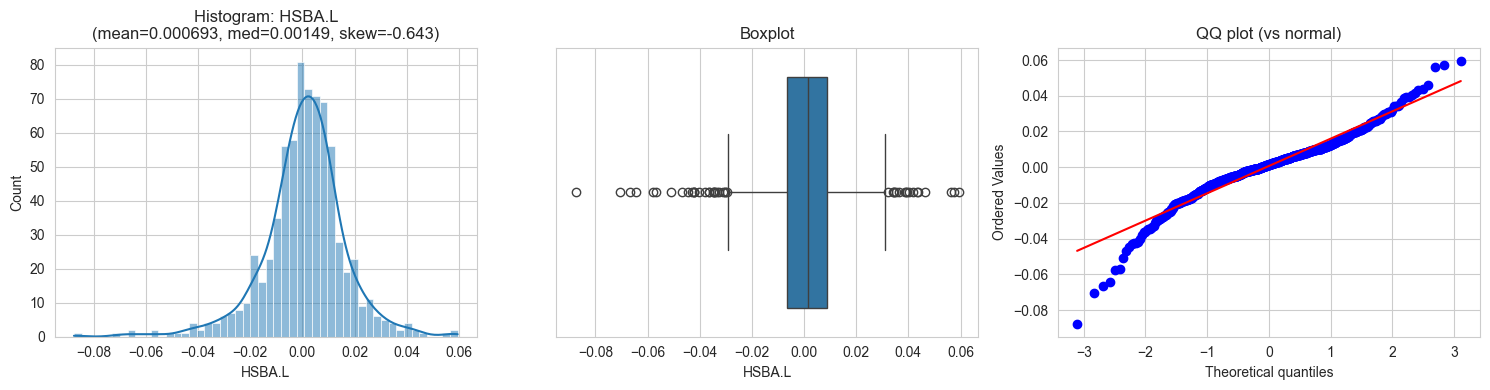

In [27]:
# Since the data seem quite skewed, we will apply a log return transformation
for ticker in tickers:
    data[("Log_Returns", ticker)] = np.log(data["Adj Close"][ticker]).diff()

data.dropna(inplace=True)

eda.plot_numeric_univariate(data["Log_Returns"], cols=data["Log_Returns"].columns.tolist(), bins=50)

Question - what to do with skewed data?


In [ ]:
# Obtain outliers based on IQR method 

eda.detect_outliers_iqr(data["Log_Returns"], cols=data["Log_Returns"].columns.tolist())

,n_outliers,pct_outliers
column,,
HSBA.L,44,6.002729
JPM,36,4.911323
BNP.PA,35,4.774898
MS,34,4.638472
BAC,33,4.502046
UBS,33,4.502046
BARC.L,31,4.229195
GS,27,3.683492
C,23,3.137790


Also from the boxplots, we note that GS and MS have significant outliers - we want to investigate these further.

<Axes: title={'center': 'MS Log Returns Time Series'}, xlabel='Date'>

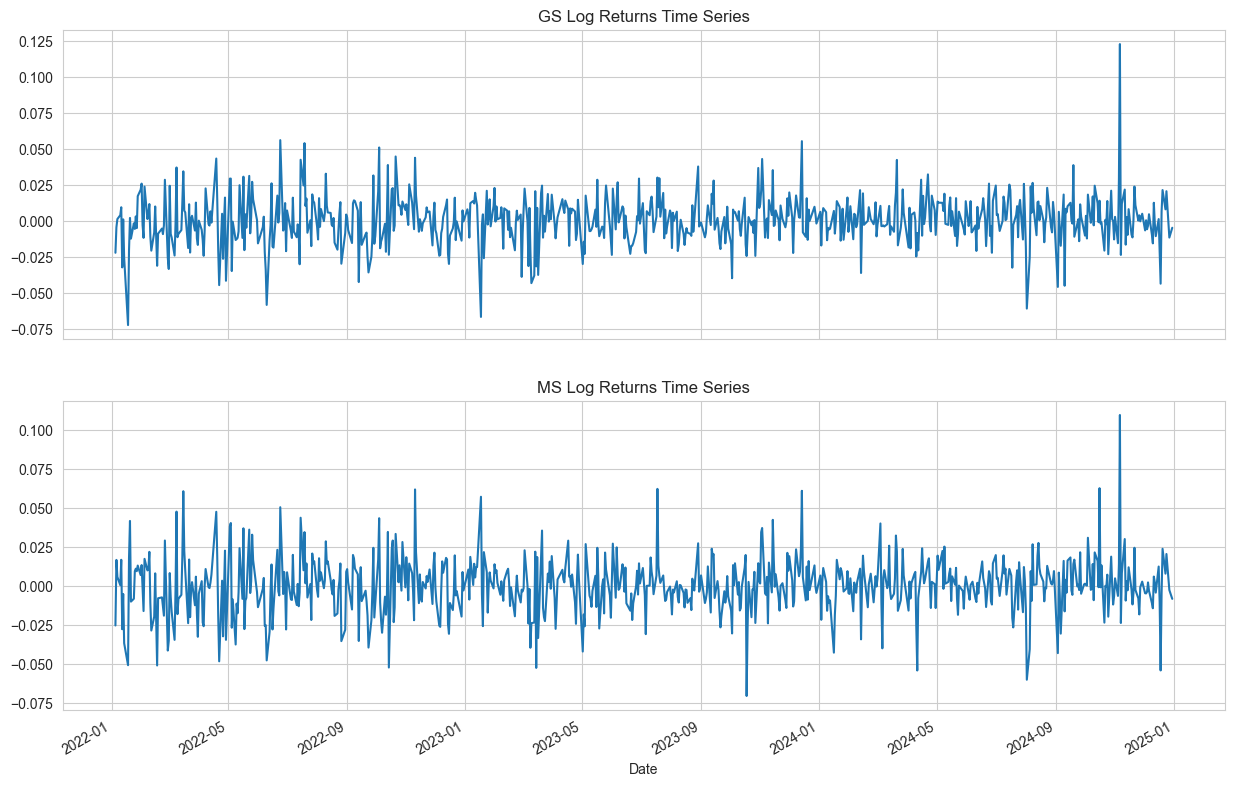

In [31]:
gs_return_series = data["Log_Returns"]["GS"]
ms_return_series = data["Log_Returns"]["MS"]

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,10), sharex=True)
gs_return_series.plot(ax=ax[0], title='GS Log Returns Time Series')
ms_return_series.plot(ax=ax[1], title='MS Log Returns Time Series') 

It seems both days have the same spike in log returns on the same day - identify the date.

In [42]:
print("The day which log returns was unusually high for GS:", gs_return_series.index[np.argmax(gs_return_series)])
print("The day which log returns was unusually high for MS:", ms_return_series.index[np.argmax(ms_return_series)])


print("\n" + "=" * 30 + " Continuing for the other stocks " + "=" * 30)
jpmc_return_series = data["Log_Returns"]["JPM"]
bac_return_series = data["Log_Returns"]["BAC"]

print("The day which log returns was unusually high for JPMC:", jpmc_return_series.index[np.argmax(jpmc_return_series)])
print("The day which log returns was unusually high for BAC:", bac_return_series.index[np.argmax(bac_return_series)])

print("\n" + "=" * 30 + " Conclusion: " + "=" * 30)
print("Upon inspection the spike in log returns was becaused of the win in the presidential election by Trump on 6th November 2024. Since we do not expect such an event to be repeated, we will remove these outliers from our dataset for training.")

The day which log returns was unusually high for GS: 2024-11-06 00:00:00
The day which log returns was unusually high for MS: 2024-11-06 00:00:00

============================== Continuing for the other stocks ==============================
The day which log returns was unusually high for JPMC: 2024-11-06 00:00:00
The day which log returns was unusually high for BAC: 2024-11-06 00:00:00

============================== Conclusion: ==============================
Upon inspection the spike in log returns was becaused of the win in the presidential election by Trump on 6th November 2024. Since we do not expect such an event to be repeated, we will remove these outliers from our dataset for training.


# Volume EDA 

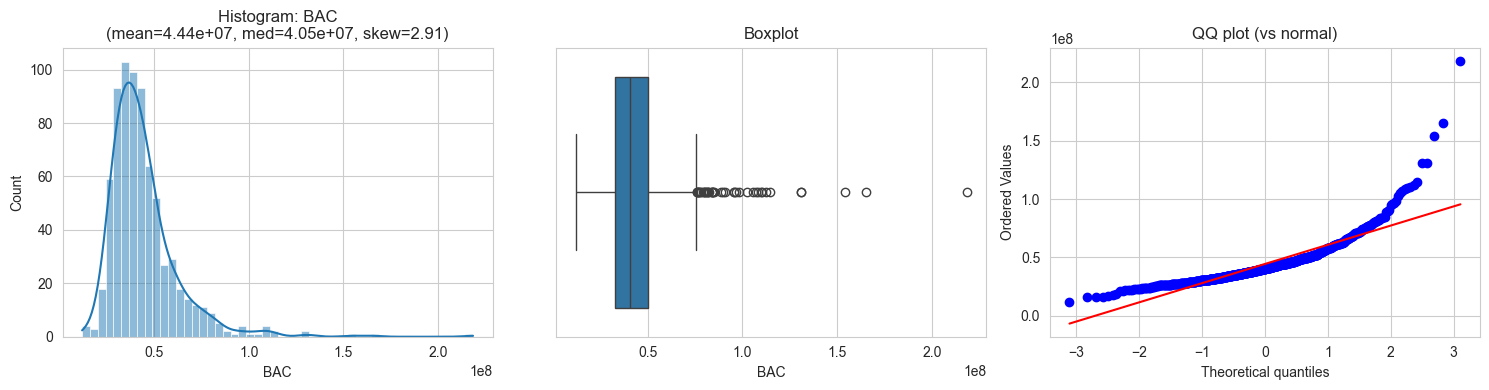

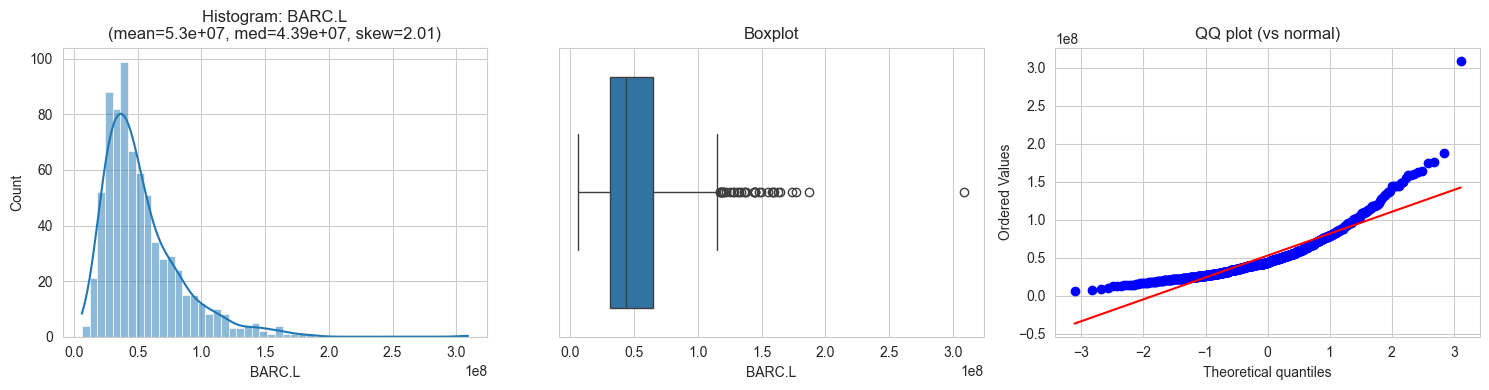

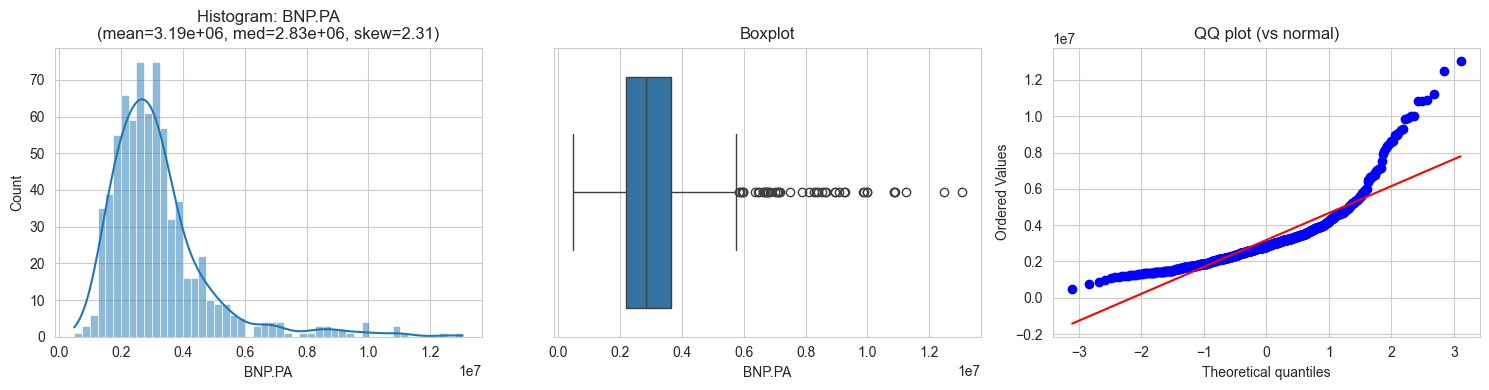

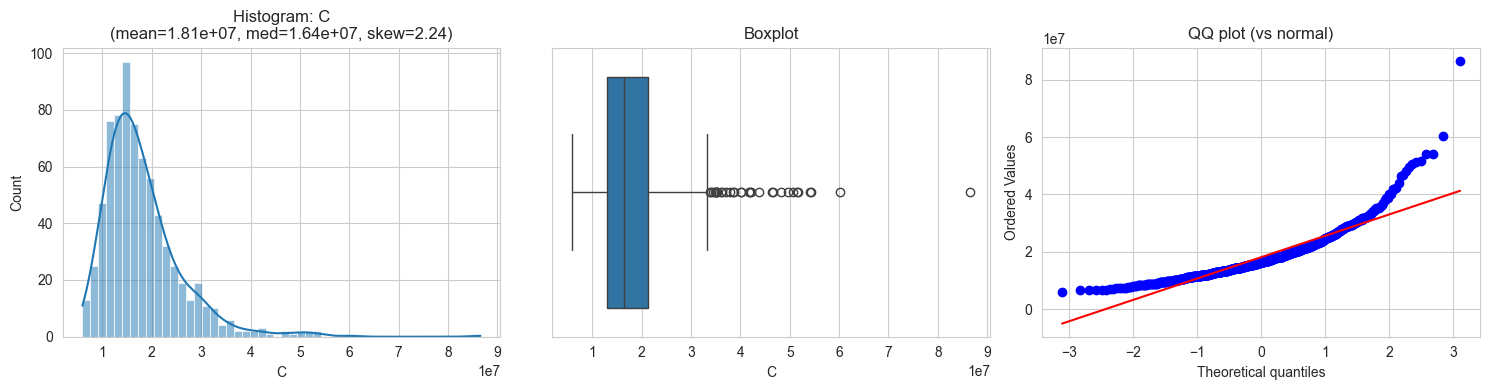

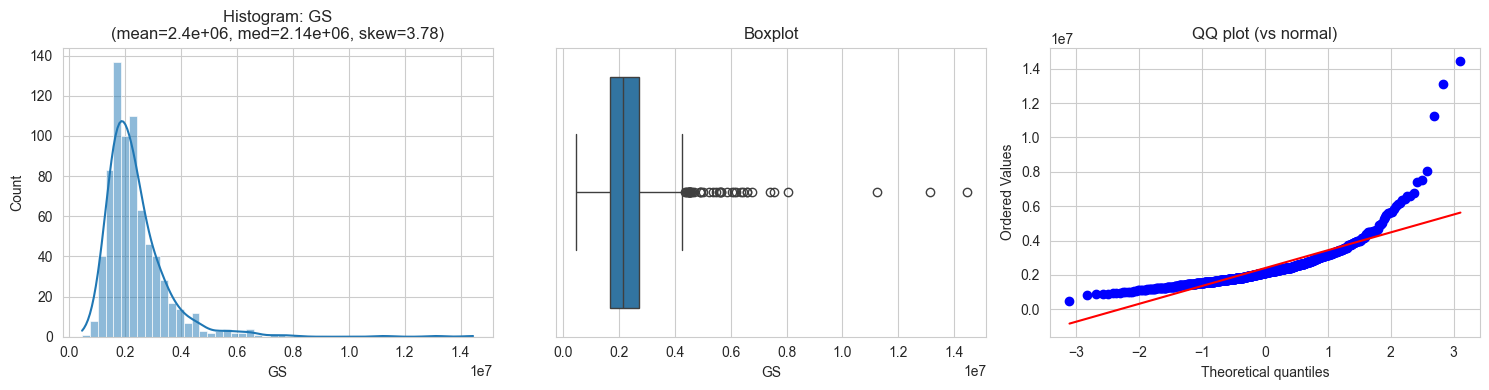

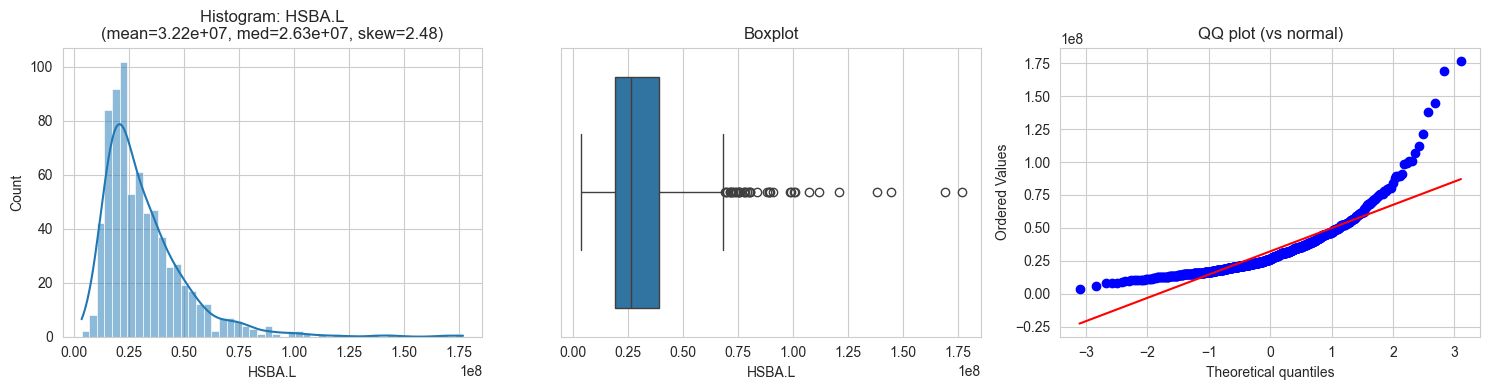

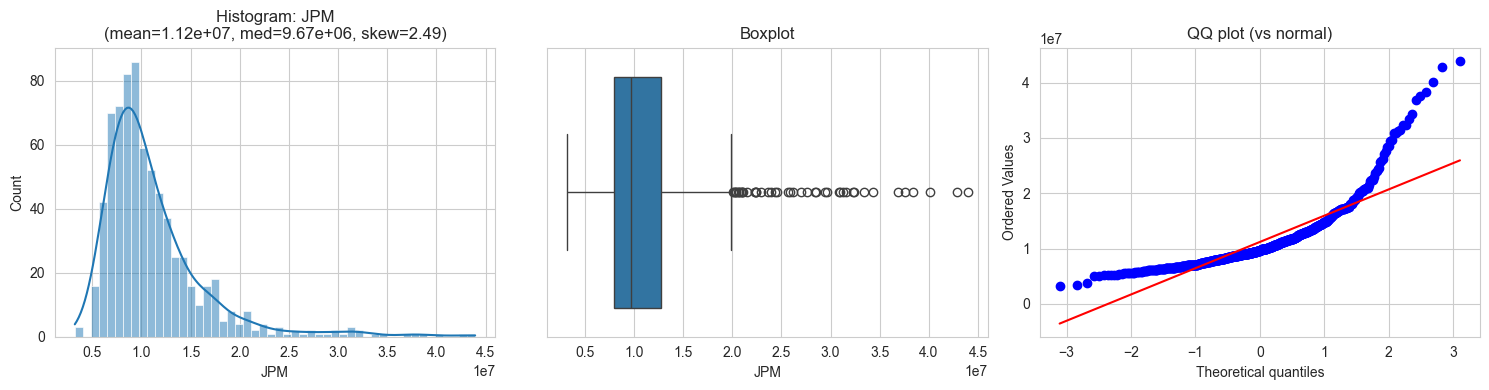

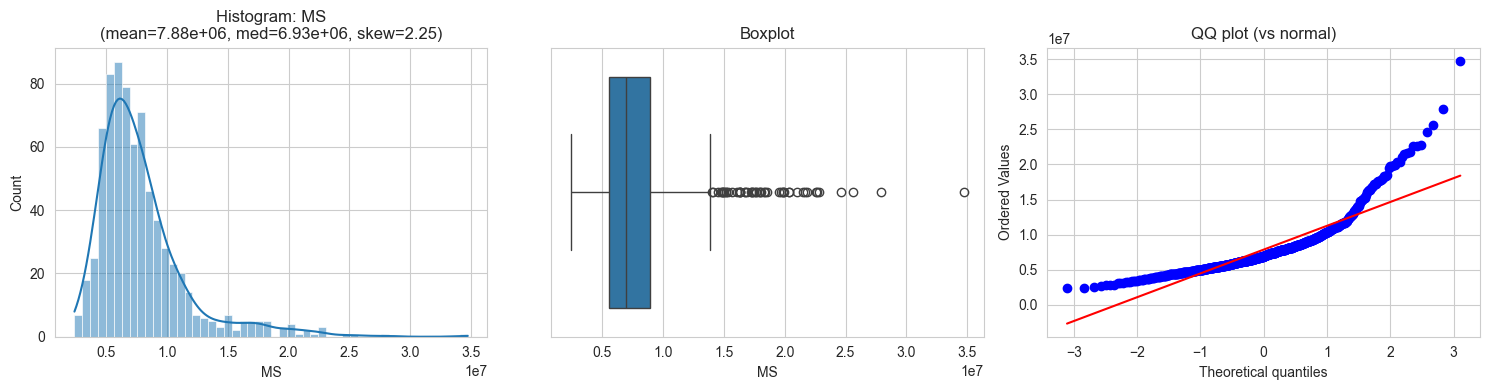

In [43]:
volume_data = data["Volume"]
eda.plot_numeric_univariate(volume_data, cols=volume_data.columns.tolist(), bins=50)

## Identificaton of Outlier Volume Trading Date 

In [45]:
ms_volume_series = data["Volume"]["MS"]
citi_volume_series = data["Volume"]["C"]

print("Volume was unusually high for MS on:", ms_volume_series.index[np.argmax(ms_volume_series)])
print("Volume was unusually high for C on:", citi_volume_series.index[np.argmax(citi_volume_series)])

Volume was unusually high for MS on: 2023-10-18 00:00:00
Volume was unusually high for C on: 2022-07-15 00:00:00


Both of these dates correspond to earnings publication dates for both these stocks, which explains the high volume. 

# Correlation Plots 

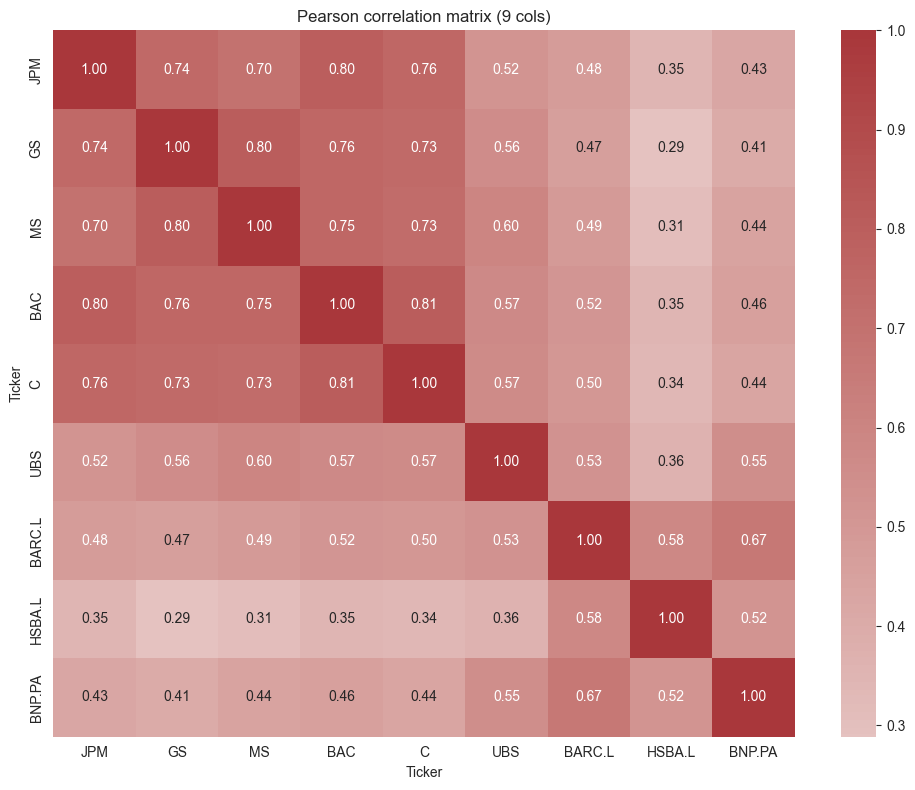

The minimum correlation is: 0.2885464980291896 and occurs between: GS and HSBA.L
The maximum correlation is: 0.8060813989115028 and occurs between: BAC and C


In [47]:
matrix = eda.correlation_matrix(data["Log_Returns"], cols=data["Log_Returns"].columns.tolist())
print("The minimum correlation is:", matrix.min().min(), "and occurs between:", data["Log_Returns"].columns[np.where(matrix == matrix.min().min())[0][0]], "and", data["Log_Returns"].columns[np.where(matrix == matrix.min().min())[1][0]])
print("The maximum correlation is:", matrix[matrix < 1].max().max(), "and occurs between:", data["Log_Returns"].columns[np.where(matrix == matrix[matrix < 1].max().max())[0][0]], "and", data["Log_Returns"].columns[np.where(matrix == matrix[matrix < 1].max().max())[1][0]])

# <a> Further Analysis </a> 

Currently note the following:

1. The correlation is very high. Consider doing PCA to reduce dimensionality and run an ARIMA on the principal components instead.

